In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/aco_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
import numpy as np

def calculate_conflicts(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

def ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Initially set the number of colors to the number of nodes
    best_iter = 0
    
    # Initialize pheromone matrix with small random values
    pheromone_matrix = np.random.rand(num_edges, num_colors)
    
    # Initialize best coloring and its value
    best_coloring = np.zeros(num_edges, dtype=int)
    best_value = float('inf')
    
    for iteration in range(num_iterations):
        # Initialize ant solutions
        ant_solutions = np.zeros((num_ants, num_edges), dtype=int)
        
        # Construct ant solutions
        for ant in range(num_ants):
            for edge in range(num_edges):
                probabilities = np.zeros(num_colors)
                if graph.has_node(edge):  # Check if edge is a valid node
                    for color in range(num_colors):
                        probabilities[color] = (pheromone_matrix[edge][color] ** alpha) * ((1 / (graph.degree(edge) + 1)) ** beta)
                    
                sum_probabilities = np.sum(probabilities)
                if sum_probabilities == 0:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                else:
                    probabilities /= sum_probabilities
                ant_solutions[ant][edge] = np.random.choice(range(num_colors), p=probabilities)
        
        # Update pheromone matrix locally
        for ant in range(num_ants):
            value = calculate_conflicts(graph, ant_solutions[ant])
            if value < best_value:
                best_value = value
                best_coloring = ant_solutions[ant]
                best_iter = iteration
                for edge in range(num_edges):
                    pheromone_matrix[edge][ant_solutions[ant][edge]] += pheromone_deposit
        
        # Global update of pheromone matrix
        pheromone_matrix *= (1 - evaporation_rate)
        for edge in range(num_edges):
            for color in range(num_colors):
                if color == best_coloring[edge]:
                    pheromone_matrix[edge][color] += pheromone_deposit / (best_value + 1e-10)

    # Update number of colors if a better coloring is found
        if value < best_value  and is_valid_coloring(graph, ant_solutions[ant]):
            best_coloring = ant_solutions[ant]
            best_value = value
            best_iter = iteration
    
    return best_coloring, best_value, len(np.unique(best_coloring)), best_iter

In [9]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    num_ants = 10
    num_iterations = 500
    
    alpha = 1
    beta = 1
    evaporation_rate = 0.2
    pheromone_deposit = 1
    
    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_coloring, best_value, num_colors, best_iter = ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit)
            end_time = time.time()
            print("Best Coloring:", best_coloring)
            print("Best Value:", best_value)
            print("Number of Colors:", num_colors)
            write_output(graph, file, best_coloring, best_iter, start_time, end_time)

Running test graph_101_edges.txt...


Best Coloring: [88 36 17 48  2 41 27  8 99 32 67  3  0 81 37 90 46 74 40 81 17 50 65 75
 38 19 19  4 40 64 42 74 98  7 65 72 45 25 89 15 90  4 80 46 39 31 22 53
  2 21 91 24 49 23 30 25 33 76 69 56 35 29 80 39 28 79 61 11 19 67 23 49
 16 37 67 45  8 97 61 50 49 58 93 54 51 36 60  0 40  1 17 71 59 48 84 55
 15  1 68 81 87]
Best Value: 0
Number of Colors: 69
[88 36 17 48  2 41 27  8 99 32 67  3  0 81 37 90 46 74 40 81 17 50 65 75
 38 19 19  4 40 64 42 74 98  7 65 72 45 25 89 15 90  4 80 46 39 31 22 53
  2 21 91 24 49 23 30 25 33 76 69 56 35 29 80 39 28 79 61 11 19 67 23 49
 16 37 67 45  8 97 61 50 49 58 93 54 51 36 60  0 40  1 17 71 59 48 84 55
 15  1 68 81 87]
Minimum edge coloring found.
Number of colors: 69
Number of iterations: 55


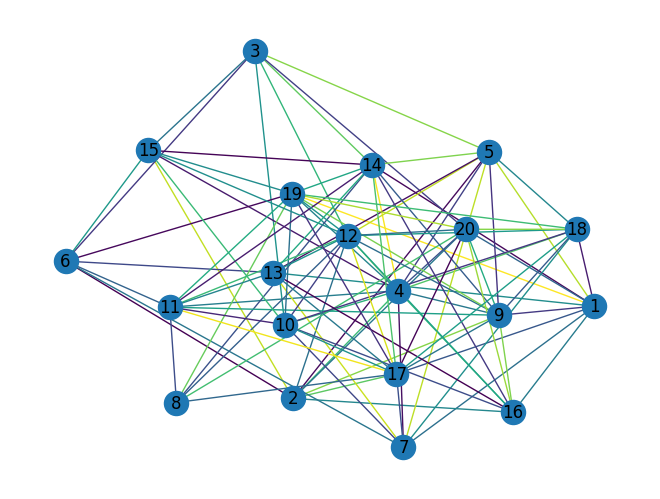

Time taken: 212.6749234199524 seconds

Running test graph_121_edges.txt...
Best Coloring: [ 47  87  52  82  44  25  88 120 100   1  67  18  60  48  48   4 109  19
 120  26  40  29  78   5 118  84 117  55 102  68  70  21  32  31  58  39
  16  55  78   9  60 115  14  85 109  87  69  77 117  79  97   3 114  66
  61 114 109  85 106   2  48  14  54 101 108  99  97  41  63  74  77  46
  24 113 107   7 108  96  47  81   0 105 119  48  75  99 119  85  88  28
  57 113  52 102  19 120  50   0  27  36 115 105  17 116  45  16  17  78
 120  14  56  21  90  79  32  21 106  83  11  51  80]
Best Value: 4
Number of Colors: 81
[ 47  87  52  82  44  25  88 120 100   1  67  18  60  48  48   4 109  19
 120  26  40  29  78   5 118  84 117  55 102  68  70  21  32  31  58  39
  16  55  78   9  60 115  14  85 109  87  69  77 117  79  97   3 114  66
  61 114 109  85 106   2  48  14  54 101 108  99  97  41  63  74  77  46
  24 113 107   7 108  96  47  81   0 105 119  48  75  99 119  85  88  28
  57 113  52 102  

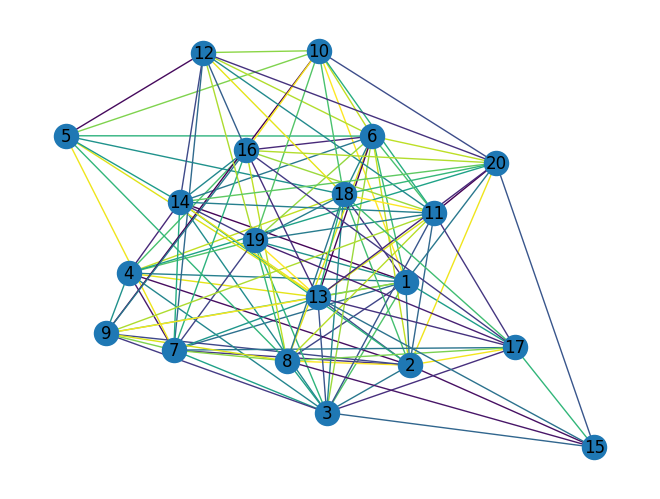

Time taken: 255.89340472221375 seconds

Running test graph_140_edges.txt...
Best Coloring: [ 27  23 132 111 127  72   7  77  63   6 114  16 119  95 116  92  21  88
 105 122   0  41 138  65  25  18  62  81  30  33 113 122  65  91 134  90
  20   5  38 119 129  77 113   1  73 131   8  23 120  15  58  69 124  89
  71  79 128  17  46  83  18  22  70 136  32 124  34  84 110  93  49  95
 126   3  36  46  55 112   5  30 113 106  22  78  22  31  28 117   3  15
  62  57 108 115  37  61 106  65  55  52  70 136  55   2  22  70 113  16
  71 115 123 128 121  96  69  71  38  24  12 127  50  31  53   0 124 109
  98 131  74  72  56 123  79 134  77 105  99   2  31 125]
Best Value: 6
Number of Colors: 93
[ 27  23 132 111 127  72   7  77  63   6 114  16 119  95 116  92  21  88
 105 122   0  41 138  65  25  18  62  81  30  33 113 122  65  91 134  90
  20   5  38 119 129  77 113   1  73 131   8  23 120  15  58  69 124  89
  71  79 128  17  46  83  18  22  70 136  32 124  34  84 110  93  49  95
 126   3  36 

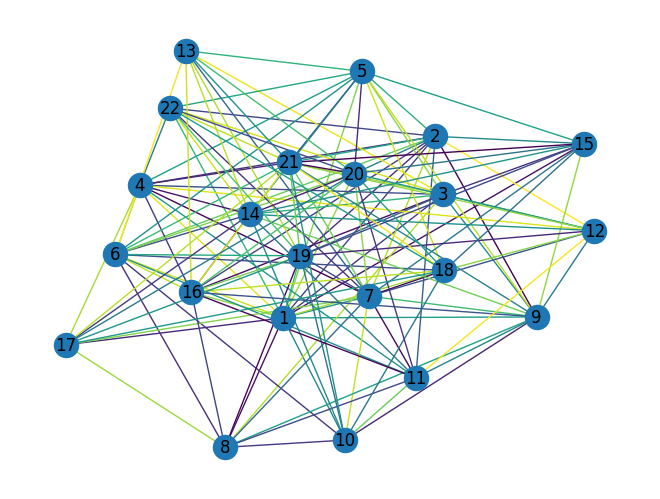

Time taken: 236.79036116600037 seconds

Running test graph_156_edges.txt...
Best Coloring: [110 148  54  55  15  57  84  90  98 146  14  99  70 121 130  35  18  95
 136  87  15 112  54  41 144 149   3  66 141  14  14 104  43 127  65 149
  44 113 134  19  59  73  82  93 152 120  69 117 114 124  40  77 122 153
  91  68  53  21  31 154 143  71 138  29 133 123  58  38  58  79 131  48
 146  51  81  73 123 112 113 153  31  42  40 121   2 116  13  94 128  52
  39  78 125  69  82 118  45 152 107 151  27  82  61  24 124  66 102  43
 104  26 146  74 118   0  38  52 116  15   4  26  52 138 154  71  98  32
  32 110  74 135 148 138  76  89  17 136  71  72 143  32 147 113  31 121
  19  44  38 155 143 154 103 117 126  11  34  93]
Best Value: 6
Number of Colors: 102
[110 148  54  55  15  57  84  90  98 146  14  99  70 121 130  35  18  95
 136  87  15 112  54  41 144 149   3  66 141  14  14 104  43 127  65 149
  44 113 134  19  59  73  82  93 152 120  69 117 114 124  40  77 122 153
  91  68  53  21  31

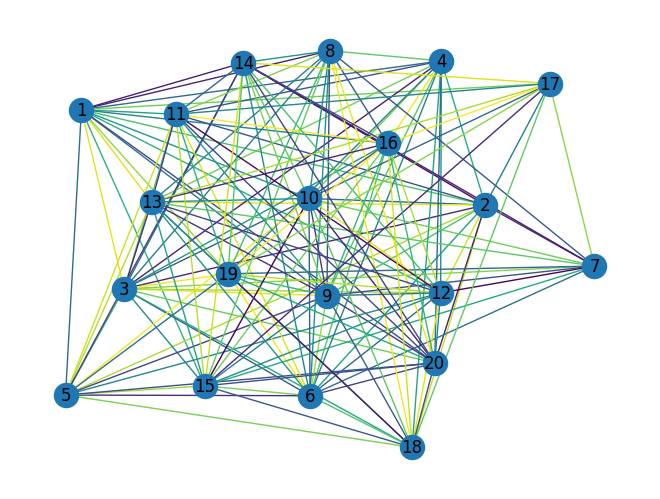

Time taken: 202.3399510383606 seconds

Running test graph_165_edges.txt...
Best Coloring: [  0 128 105  55  38  43  10  90  35 142  75  73  93  24  45 138 123 156
 100 112  75  12  90  69 158 116   8  90 101 141  58  71  71  93 160  43
 102  89 158  32  10  54 120 151  11  56  93  24  43  98 112  61  57 133
  36  77 119  53  30  96 162 159  86  57  28 131 155  42  12  33  63 163
 121  16  40 158  94  71   5 100  76  65 152  84 116 152  22  57  94  72
  89  79  52 160  16  11 144  67  72 102 135 126 107 154  76  52  95  97
 115 110 103 100  46 128 147 119  45 149  30  83  86  76 148   2   4  68
 122  37  53 108  94   6  77  95 108 101 127 133  79 138  65 155 105 112
  26  87  55 114   4 123 141  18 139  69  39 142  23 149  71  72  44  20
  42  19 105]
Best Value: 2
Number of Colors: 105
[  0 128 105  55  38  43  10  90  35 142  75  73  93  24  45 138 123 156
 100 112  75  12  90  69 158 116   8  90 101 141  58  71  71  93 160  43
 102  89 158  32  10  54 120 151  11  56  93  24  43  98 

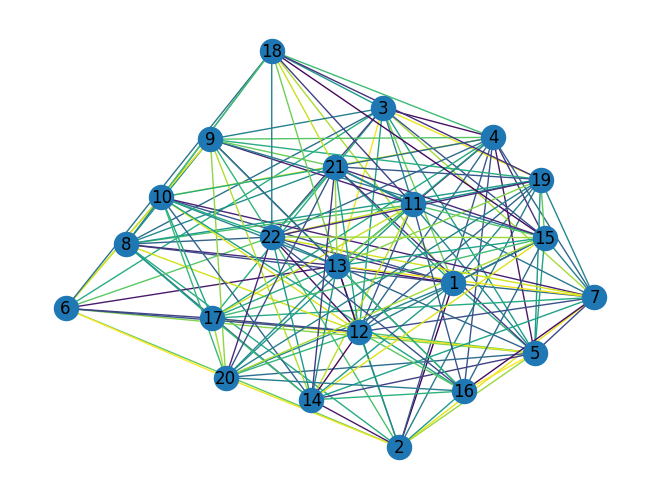

Time taken: 217.028005361557 seconds

Running test graph_177_edges.txt...
Best Coloring: [ 79  85 131  58 148  72 133  96  36  92  88 158 172  94  20  16 121  62
 173   2 136 112 120  89 156 116  30  12 124 104  67  96 136  53   5  86
 154  31  14 171 100 117  69  68  54  35 134 133 159 135  10  35  98 108
  24  40  14  34  91 110  53  15   1  46   3   8  45 133 144  23   9  29
  27  55  38  88  21 164 110  65  31  66 173   6  69  40  28 152 106  90
   0 163  12  56  53  84 130  55  40  65  21 105 164  39 100   9  65  43
  69  54  62  92  90  70  87 154  70 169 109 169  56 154 126  26  32  72
 165 102 124 162 160 176  98  72 112  66  88  33  44   5  48 132 105  14
 131 149  32  59 145 112 154 120 137 157 173 165  86 134  66 153  30 175
  82 108  93  25 131 110  79  68  91 111  74  38 123 115  23]
Best Value: 8
Number of Colors: 115
[ 79  85 131  58 148  72 133  96  36  92  88 158 172  94  20  16 121  62
 173   2 136 112 120  89 156 116  30  12 124 104  67  96 136  53   5  86
 154  31  

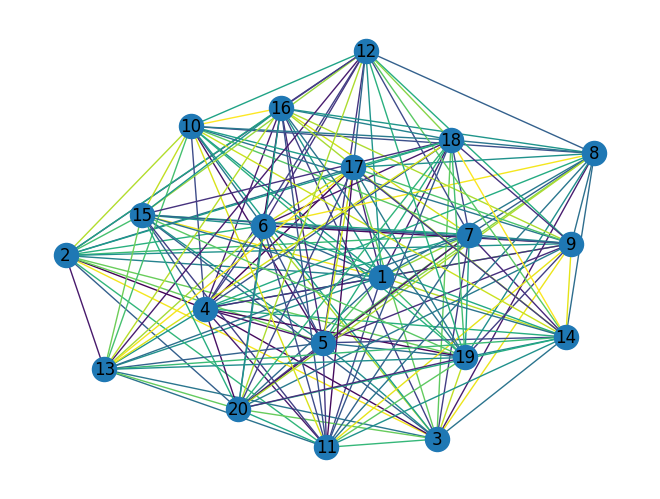

Time taken: 230.63174057006836 seconds

Running test graph_204_edges.txt...
Best Coloring: [111 132  82 154 191 188 114 171  33  59 134 156  58 100 140  40 139  15
  42  22  73 193 101 194 106 110  14  31  70  21 145  78 144  38 124  24
  86 139  81 144  65 180 188  30 191 203  25 137 101 102  42  65  27  83
  74  42  94  51  53  40 103 120 106 114  33 100 165 136   4 147  28  10
  17 134   4  36 114  62  14 175  84 131 191 122 137 149 150 141  72 101
  99  59 125  87 190 118  89  17 198 142  42  81 130 173 168 195  90  57
  15 201 169  35  85  50 197  86  28  73   8  13 183  57 102  88 164 192
 181  37 117   9  89  91  67  48  77 137 118 179 158 179 104 121 180 122
  74 200 100 168  84   8 125  79 145  23  25  69 198 170 101 200  98  33
  77  73 177   4 160  67 126 154 139 171  66 175  55 177  24  47  38 153
 198 177 152 173  64 103  83 160  34  63 155 150 192 106 134  90  84  19
 153  82  91 142  39  44]
Best Value: 4
Number of Colors: 129
[111 132  82 154 191 188 114 171  33  59 134

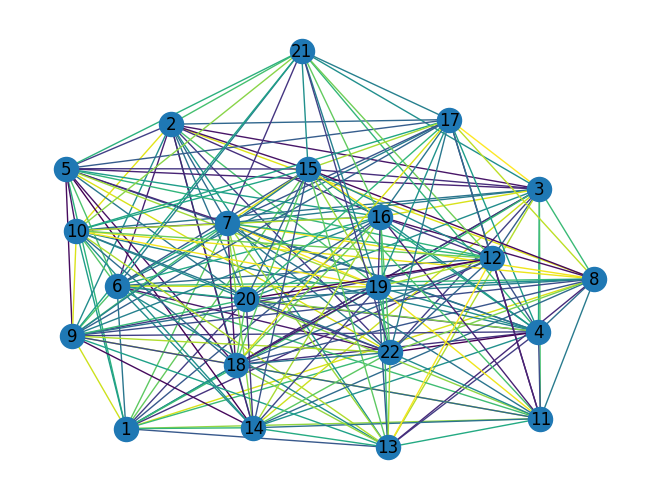

Time taken: 287.3292987346649 seconds

Running test graph_227_edges.txt...
Best Coloring: [189  97 192  12  28  70 225  48   3 116  23 170 185  13 193 205  19  21
  12  74 129  38 118 171  32  20  42 113  79 159 216 137  66  24  49  65
  42  19  88  87   3 132 181  46 200  20 112 214  87 176  30 120 208 173
  47   6 125  20  84 221 208 192 165  80 214 167 179  15 123  97  68 162
   4 153 106  75  31  37  11  61 184 151 173 134  68 150  87 103 167  99
 208 123  59 225 162 214  35 123  98 193 145 216  63  62  99 101  61  87
 181 166 226   6 141 185  34  28 134 144  13  93 174  89 144  44 172 177
  47 220 136  55 141  91 121 117 113  10  48  88 129 226 149  34 222  99
 107 175  51 180 162  73 105 160 121  92 180  78 185  95 167 149  53 189
  70 192 200 158 113  91 195 175  51 222 216   8  44 135  21  18  12 121
 107  30  44 151  16  35  52 105 152 193 147 204 144 157  14   9 192 127
 167 104  49 215 115 126  57 196  51 129 146   0 189 176 218 136 135 100
 185  55 190 159  24 214  23 183 1

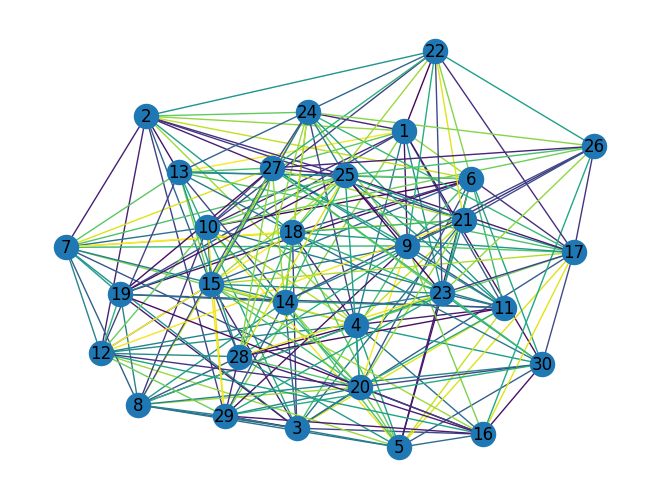

Time taken: 362.8581647872925 seconds

Running test graph_273_edges.txt...
Best Coloring: [176 208 234 141  64 113 133  95 101 111  75  84 216  20  23 135 196 268
 214 264 254 150  86 247  79  68 246 108  21 197  40 119  53 196 161  33
  60 144 190 250  61 271  35  93  52 108 140 150 174  14  99 189  73  56
  76 121   3 205 208  90  50 192  50 173 254 208  66 222 214  15 270 246
  30 242 259 200 113  20 160  38 112 195 241 248  71  39 131  98  88  27
   8 186 203 150 183 163  82  28 262 240 137  77 235  27 124  79  80 126
 232  77 226 207 174 181  66  62  23 134 214  88 231 233 104  37 135  90
 143 259 210 216 191 130  67  52  62 105 201  69  82  40 262 107 215 234
  81 230 135 240 145  61  91 247  57 161 246 167 261   4 128  10 231  14
 208  18  86 224 134 256  26  44 170 147 111 225 141 215 131  51 122  59
  51  12 265 201  64  99 115 144  66 224 209   5 170 225  71  16 193  33
  93 123 159 264 251  74 187 225 113  49 239 150  56   8 118   7  74  91
  12  84   2 262 257 209  36 223 2

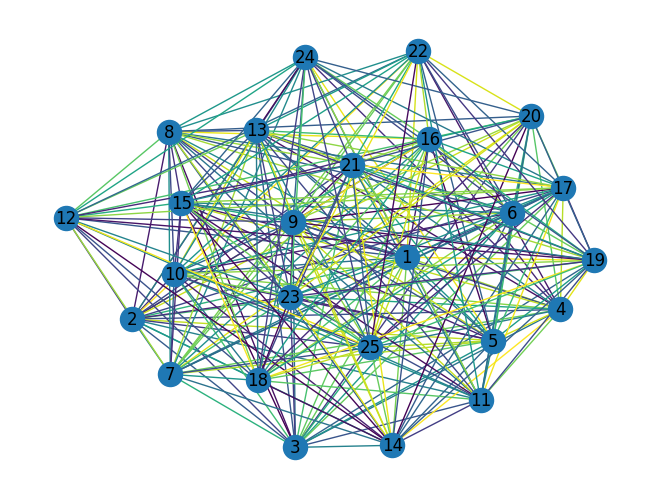

Time taken: 478.4196572303772 seconds

Running test graph_275_edges.txt...
Best Coloring: [186  17  37  43 254  23 193 170 191  93 102  38 198  22  47  92  42  90
 188 129 120 187 153 104 156  98 132  79  12  74 248 264 237 269  86 228
  44   1  30 119 232 217  77 151 197 161  95 192 270 255  80 157 152 185
 159  71 184 237 274  41 252 273 150 272  54  96 218 195 246 173  49  23
  36 235 133 204 212 146 113 199   5  30 202  54 148 102  16  60 257  66
 156 155 104 244 265 182   0 237  25 230   0 121 143 244 181 224  54  61
  78 214 144 187 270  33  62 152 242 227 145 151 231 215 269  16 204 261
 233 176 219 150 197   3 104  67  37  68 117 170 106 153   5  77 206  17
   7 236 188 147 154 188  73  76 232 138 162 197  26 261  65 164  51 222
  67 137  56 155 256  70 183  88  15 231 160 142 115  25 149 191 172  12
 173 130 150 179  87 175 113  52  42 251 261 214 205  74 102 172 238  48
 243 272  91 127   6 270  46 186 246 119  76 151 220 247 236 179 162 232
   4 134   7  34 149 135 243  78  

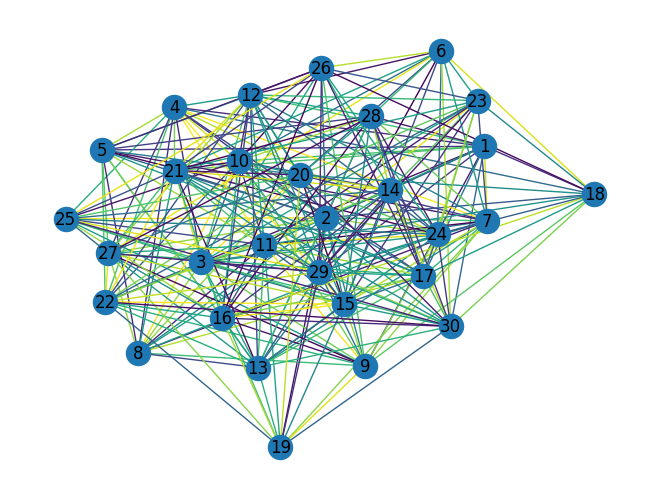

Time taken: 460.3048105239868 seconds



In [10]:
with open('./results/aco_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')